## Datos poblacion CNPV 2018 - Bogota

This notebook uses the API to request population information by block in bogota and the region.

API Example: 
https://geoportal.dane.gov.co/laboratorio/serviciosjson/poblacion/indicadordatospoligonos_2.php?coordendas=-74.08876161847364,4.6541400936972455,-74.08587556157362,4.655241519148368,-74.08396582875501,4.653049359998433,-74.08458810124647,4.6512100797376545

Methods: 

- Simplify polygon complexity: Reduce the number of edges so that area difference is +- 3%. Max number of edges should be less than 10. Options to do this: Convex_hall, or simplify, or a combination of the both.
- Transform edges to x,y coordinates, and then to a string. 
- Paste web site and x,y str object. 
- Request information
- Validation of results 
    - Sum of the population 
    - Comparison with 2010 population by block 

In [1]:
import requests
import pandas as pd 
import numpy as np
import geopandas as gpd
import time

In [2]:
def _get_population(polygon):
    ''' 
    Obtains the population of a given polygon in Colombia
    - Input: Shapely Polygon object, CRS: EPSG:4686
    Returns number of units, households and persons in the given polygon'''
    
    
    page = 'https://geoportal.dane.gov.co/laboratorio/serviciosjson/poblacion/indicadordatospoligonos_2.php?coordendas='
    #Get polygon edges x, y coordinates
    x, y = polygon.exterior.coords.xy
    
    assert len(x) <= 20
    assert len(y) <= 20
    
    x, y = np.array(x).reshape(-1,1), np.array(y).reshape(-1,1)
    separator = ', '
    coors = separator.join(np.concatenate((x,y), axis = 1).flatten().astype(str)).replace(" ", "")

    #Building URL 
    url = page + coors
    r = requests.get(url)
    return r.json()

In [3]:
def simplify_geometry(blocks, geo_type = 'convex_hull', plots = False):
    if geo_type == 'convex_hull':
        geometry = blocks.geometry.convex_hull
    
    elif geo_type == 'simplify':
        geometry = blocks.geometry.simplify(tolerance = 0.5, preserve_topology = True)
    
    else:
        geometry = blocks.geometry.buffer(0)
    
    #Setting the new geometry
    blocks['geo'] = geometry 
    blocks = blocks.set_geometry('geo')
    
    #counting edges
    list_edges_counts = []
    for element in geometry:
        edges = len(element.exterior.coords)
        list_edges_counts.append(edges)
        
    #plot edges distribution 
    blocks['edges'] = pd.Series(list_edges_counts);
    blocks = blocks[blocks.ESTRATO !=0 ]
    
    if plots == True: 
        blocks.edges.plot.hist(bins = 20)
        #Plot map
        blocks.plot(figsize = (20,20))
        print(blocks.edges.max())
    return blocks

In [4]:
def get_population(blocks_file):
    '''
    Gets population variable on a given set of blocks
    Input:
    - block_files: Geopandas dataframe with block polygon shapes
    '''
    dict_list = []
    
    for block in blocks_file.geo:
        request = _get_population(block)['resultado']
        try:
            dict_list.append(request[0])
        except IndexError:
            dict_list.append(dict())
            
    df = pd.DataFrame(dict_list, index = blocks_file.index)
    blocks = pd.concat((blocks_file, df), axis = 1)
    
    return blocks

## Results

In [9]:
input_path = "../../data/input/"
path = input_path + 'manzanaestratificacion/ManzanaEstratificacion.shp'
blocks = gpd.read_file(path)

Best method to simplify the blocks is to first do a convex hull, and then, the simplify. 

5.0


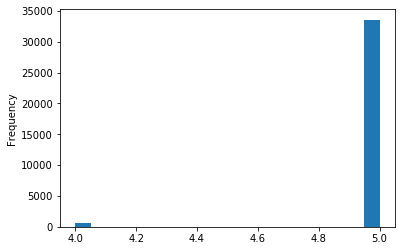

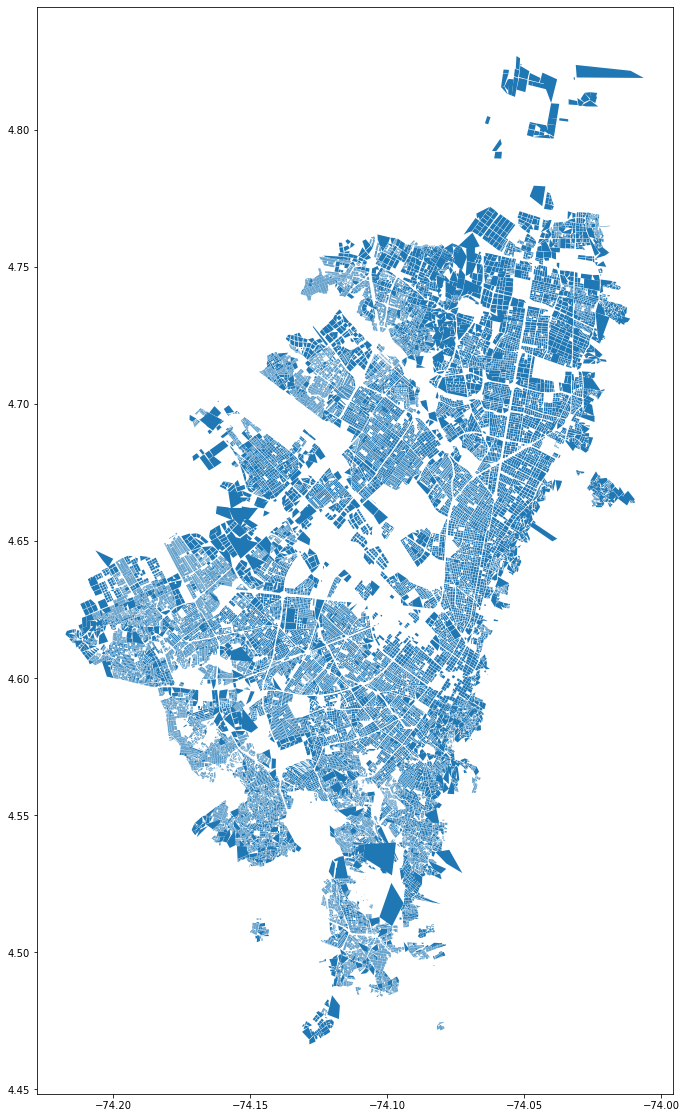

In [8]:
blocks = simplify_geometry(blocks, geo_type = 'convex_hull', plots = False)
blocks = simplify_geometry(blocks, geo_type = 'simplify', plots = True)

In [ ]:
%%time
blocks_pop = get_population(blocks)

note: This took a long time to run. I estimate it was 12h, but the jupyter notebook stop responding and printing the results

In [159]:
#Save results: 
blocks_pop = blocks_pop.set_geometry(col = 'geometry')
blocks_pop = blocks_pop.drop('geo', axis = 1)

In [161]:
path = input_path + 'blocks_pop_2018/blocks_pop_2018.shp'
blocks_pop.to_file(path)

In [15]:
# blocks_pop.to_csv('blocks_strata_population.csv')

## Validation 

In [45]:
#CENSO 2018
true_pop = 7181469
true_hh = 2514482

persons = blocks_pop.TOTAL_PERSONAS_HOGAR.fillna(0).astype('int').sum()
households = blocks_pop.TOTAL_DE_HOGARES.fillna(0).astype('int').sum()
print('Total personas: ', persons, " | Difference: ", true_pop - persons)
print('Total hogares: ', households," | Difference: ", true_hh - households)

Total personas:  7008362  | Difference:  173107
Total hogares:  2464269  | Difference:  50213


There are 171.107 persons, and 50.213 households missing from my previous scrip. That is ~2.5% of the population

For now, I think this is OK. It looks that missing blocks are pretty much random, so I don't believe is a huge problem if I don't have the whole population. Plus, I only use the population to get some probabilities and weights. 